Naive Bayes classifier for Pitchfork reviews

Simran Batra

DS 5559

# Configuration

In [1]:
src_file = 'pitchfork.csv'

OHCO = ['Title', 'Artist', 'Author', 'Date','Genre', 'Score', 'para_num', 'sent_num', 'token_num']
TITLE = OHCO[:1]
ARTIST = OHCO[:2]
AUTHOR = OHCO[:3]
DATE = OHCO[:4]
GENRE = OHCO[:5]
SCORE = OHCO[:6]
PARAS = OHCO[:7]
SENTS = OHCO[:8]

In [2]:
class Params():
    qntile_P = .9
    qntile_N = .1
    n_sets = 4
    smooth_alpha = .1
    binary_mode = True
params = Params()

## Loading libraries 

In [3]:
import pandas as pd
import numpy as np
from numpy import log2 as log
from numpy import exp2 as exp
from numpy.random import randint
import textman as tx
import sqlite3

In [4]:
%matplotlib inline

## Loading data

In [5]:
docs = pd.read_csv("pitchfork.csv", encoding="ISO-8859-1")
docs = docs[["Text", "Score"]]
docs.index.name = "doc_id"

# Convert points to labels

## Keep only reviews with high and low ratings

In [6]:
bound_P = int(docs['Score'].quantile(params.qntile_P))
bound_N = int(docs['Score'].quantile(params.qntile_N))
docs = docs[(docs.Score <= bound_N) | (docs.Score >= bound_P)]
docs.head()

,Text,Score
doc_id,,
1,Like a desperate magician guessing card after ...,4.8
10,In a T Magazine interview with Solange publish...,8.4
18,"Premonitions, the debut album by unabashed Los...",8.1
19,Saves the Day have long operated with an infla...,3.5
22,Tory Lanez tries so damn hard at everything he...,5.0


## Assign labels for high and low

In [7]:
docs.loc[docs['Score'] >= bound_P, 'doc_label'] = 'P'
docs.loc[docs['Score'] <= bound_N, 'doc_label'] = 'N'

In [8]:
docs = docs.drop('Score', 1)
docs.head()

,Text,doc_label
doc_id,,
1,Like a desperate magician guessing card after ...,N
10,In a T Magazine interview with Solange publish...,P
18,"Premonitions, the debut album by unabashed Los...",P
19,Saves the Day have long operated with an infla...,N
22,Tory Lanez tries so damn hard at everything he...,N


# Divide docs into train and test sets


## Assign random numbers to docs

In [9]:
docs['set'] = randint(0,params.n_sets, len(docs.index))
docs.head()

,Text,doc_label,set
doc_id,,,
1,Like a desperate magician guessing card after ...,N,0
10,In a T Magazine interview with Solange publish...,P,0
18,"Premonitions, the debut album by unabashed Los...",P,0
19,Saves the Day have long operated with an infla...,N,2
22,Tory Lanez tries so damn hard at everything he...,N,0


## Split docs by assigned number 

In [10]:
training_docs = docs[docs.set != 0].copy()
testing_docs = docs[docs.set == 0].copy()
del(docs)

In [11]:
training_docs = training_docs.drop('set', 1)
testing_docs = testing_docs.drop('set', 1)

In [12]:
round(len(training_docs) / len(testing_docs), 2)

3.11

## Convert docs to tokens

In [13]:
training_tokens, vocab = tx.create_tokens_and_vocab(training_docs, src_col='Text')
testing_tokens, _ = tx.create_tokens_and_vocab(testing_docs, src_col='Text')

## Apply training vocab to testing

In [14]:
testing_tokens['term_id'] = testing_tokens.term_str.map(vocab.reset_index().set_index('term_str').term_id)
testing_tokens = testing_tokens.dropna()
testing_tokens['term_id'] = testing_tokens['term_id'].astype('int')

## Simplify tokens table 

In [15]:
training_tokens = training_tokens.reset_index()[['doc_id','term_id']]
testing_tokens = testing_tokens.reset_index()[['doc_id','term_id']]

In [16]:
if params.binary_mode:
    training_tokens = training_tokens.drop_duplicates()
    testing_tokens = testing_tokens.drop_duplicates()

In [17]:
training_tokens.head()

,doc_id,term_id
0,19,33210
1,19,9635
2,19,22616
3,19,26766
4,19,19584


## Transfer doc labels and splits to tokens

In [18]:
training_tokens = training_tokens.join(training_docs[['doc_label']], on='doc_id', how='inner')

In [19]:
training_tokens.head(5)

,doc_id,term_id,doc_label
0,19,33210,N
1,19,9635,N
2,19,22616,N
3,19,26766,N
4,19,19584,N


# Training

## Estimate class priors

In [20]:
Nc = training_docs['doc_label'].value_counts()
Nd = training_docs.shape[0]
class_priors = Nc / Nd

In [21]:
np.round(class_priors, 2)

P    0.78
N    0.22
Name: doc_label, dtype: float64

## Convert priors to logs


In [22]:
class_priors_log = log(class_priors)

In [23]:
np.round(class_priors_log)

P   -0.0
N   -2.0
Name: doc_label, dtype: float64

## Estimate likelihoods

In [24]:
class_likelihoods = training_tokens.groupby(['term_id', 'doc_label']).doc_label.count()\
    .unstack().fillna(0)

In [25]:
class_likelihoods = class_likelihoods + params.smooth_alpha
class_likelihoods = class_likelihoods / class_likelihoods.sum()

In [26]:
class_likelihoods.head()

doc_label,N,P
term_id,,
457,0.000001,0.000013
460,0.000037,0.000026
462,0.000001,0.000005
464,0.000072,0.000086
465,0.000096,0.000096


## Convert likelihoods to logs

In [27]:
class_likelihoods_log = log(class_likelihoods)

In [28]:
class_likelihoods_log.head()

doc_label,N,P
term_id,,
457,-19.693225,-16.203829
460,-14.739029,-15.218042
462,-19.693225,-17.483936
464,-13.762488,-13.505566
465,-13.353375,-13.340979


# Testing

## Add likelihood columns to test tokens table

In [29]:
testing_tokens.head()

,doc_id,term_id
0,1,22287
1,1,10339
2,1,5935
4,1,2321
5,1,26695


In [30]:
testing_tokens = testing_tokens\
    .join(class_likelihoods_log[['P','N']], on='term_id', how='inner')
#testing_tokens

In [31]:
testing_tokens.sample(5)

,doc_id,term_id,P,N
121669,4364,7206,-15.368459,-15.300907
89658,3286,39338,-14.545337,-15.300907
44059,1367,20065,-17.483936,-16.233793
76957,2846,30978,-11.622406,-11.665319
87480,3138,11207,-14.842831,-14.335673


In [32]:
testing_docs.index = testing_docs.index.get_level_values('doc_id')
testing_docs = testing_docs[['doc_label', 'Text']]

In [33]:
testing_tokens


,doc_id,term_id,P,N
0,1,22287,-8.626400,-8.272738
570,10,22287,-8.626400,-8.272738
1107,18,22287,-8.626400,-8.272738
1442,22,22287,-8.626400,-8.272738
1681,30,22287,-8.626400,-8.272738
2334,48,22287,-8.626400,-8.272738
2583,58,22287,-8.626400,-8.272738
3104,85,22287,-8.626400,-8.272738
4101,110,22287,-8.626400,-8.272738
4576,147,22287,-8.626400,-8.272738


## Compute posteriors 

In [34]:
testing_docs['prediction'] = testing_tokens.groupby('doc_id')\
    .apply(lambda x: x[['P','N']].sum())\
    .apply(lambda x: x + class_priors_log, 1)\
    .idxmax(1)

In [35]:
testing_docs['prediction'].value_counts()

P    356
N     54
Name: prediction, dtype: int64

In [36]:
testing_docs

,doc_label,Text,prediction
doc_id,,,
1,N,Like a desperate magician guessing card after ...,P
10,P,In a T Magazine interview with Solange publish...,P
18,P,"Premonitions, the debut album by unabashed Los...",P
22,N,Tory Lanez tries so damn hard at everything he...,N
30,P,In the final moments of Universal Beingsat th...,P
48,P,"For more than a decade, experimental percussio...",P
58,P,Before Cocteau Twins released their perfect si...,P
85,P,The silencing of women is a social plague; Bik...,P
110,P,Tom Pettys music has been obsessively compile...,P


# Evaluation

In [37]:
testing_docs['result'] = testing_docs.doc_label == testing_docs.prediction

In [38]:
testing_docs.head(30)

,doc_label,Text,prediction,result
doc_id,,,,
1,N,Like a desperate magician guessing card after ...,P,False
10,P,In a T Magazine interview with Solange publish...,P,True
18,P,"Premonitions, the debut album by unabashed Los...",P,True
22,N,Tory Lanez tries so damn hard at everything he...,N,True
30,P,In the final moments of Universal Beingsat th...,P,True
48,P,"For more than a decade, experimental percussio...",P,True
58,P,Before Cocteau Twins released their perfect si...,P,True
85,P,The silencing of women is a social plague; Bik...,P,True
110,P,Tom Pettys music has been obsessively compile...,P,True


## Show raw T & F count 

In [39]:
raw = testing_docs.result.value_counts()

In [40]:
raw

True     358
False     52
Name: result, dtype: int64

In [41]:
raw[True] / raw[False]

6.884615384615385

## Create confusion matrix 

In [42]:
CM = testing_docs.reset_index().groupby(['prediction','doc_label']).doc_id.count().unstack().fillna(0)

In [43]:
CM.columns.name = 'actual'
CM

actual,N,P
prediction,,
N,49,5
P,47,309


In [44]:
def get_results(CM):

    class Results():
        
        TP = CM.iloc[0,0] # hits
        FP = CM.iloc[0,1] # Type I errors; false alarms
        TN = CM.iloc[1,1] # correct rejections
        FN = CM.iloc[1,0] # Type  II errors; misses
        T = TP + TN
        F = FP + FN
        ALL =  T + F
        ACC = T / ALL # Accuracy
        TPR = TP / (TP + FN) # Recall, Sensitivity
        TNR = TN / (TN + FP) # Specificity
        PPV = TP / (TP + FP)  # Precision; Positive predictive value 
        BA = (TNR + TPR) / 2 # Balanced Accuracy
        F1 = (2 *  TP) / (2 * TP + FP + FN) # F-score where F =  1

        assert ALL == CM.sum().sum()
                
        def show_results(self):
            print('TPR:', round(self.TPR, 2), '(sensitivity)')
            print('TNR:', round(self.TNR, 2), '(specificity)')
            print('F1: ', round(self.F1, 2), '<-- GRADE')
            print('-'*9)
            print('PPV:', round(self.PPV, 2),  '(precision)')
            print('ACC:', round(self.ACC, 2), '(accuracy)')
            
    return Results()

In [45]:
R = get_results(CM)

In [46]:
R.show_results()

TPR: 0.51 (sensitivity)
TNR: 0.98 (specificity)
F1:  0.65 <-- GRADE
---------
PPV: 0.91 (precision)
ACC: 0.87 (accuracy)


# Exploration

## Likelihoods as Sentiment Lexicon

In [47]:
sentilex = (np.sign(class_likelihoods['P'] - class_likelihoods['N'])).to_frame()\
    .rename(columns={0:'polarity'})
sentilex['valence'] = (class_likelihoods['P'] - class_likelihoods['N']) * 1000
sentilex['term_str'] = vocab.term_str
sentilex = sentilex.set_index('term_str')

### Ratio of positive to negative terms

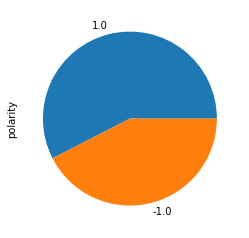

In [48]:
sentilex.polarity.value_counts().plot(kind='pie')

### Top positive terms 

In [105]:
sw = ["get", "even", "say", "one", "really", "anything", "thing", "make", "much", "like", "got", "since", "either", "still", "sort", "among", "also", "later", "within"]
sw = pd.DataFrame(sw).rename(columns={0:"term_str"})
merge = pd.merge(sentilex.reset_index(),sw, how='outer', indicator=True)
merge = merge[merge["_merge"] == "left_only"].set_index("term_str")[["polarity", "valence"]]
merge.sort_values('valence', ascending=False).head(30)

,polarity,valence
term_str,,
jazz,1.0,0.325112
black,1.0,0.299725
notes,1.0,0.290062
clear,1.0,0.271238
reissue,1.0,0.270987
different,1.0,0.265955
space,1.0,0.260207
gorgeous,1.0,0.249013
perfect,1.0,0.236702


### Top negative words 

In [106]:
merge.sort_values('valence', ascending=True).head(30)

,polarity,valence
term_str,,
least,-1.0,-0.697257
album,-1.0,-0.601253
problem,-1.0,-0.583585
bad,-1.0,-0.562979
pop,-1.0,-0.530714
enough,-1.0,-0.494635
better,-1.0,-0.493782
little,-1.0,-0.490594
actually,-1.0,-0.470315


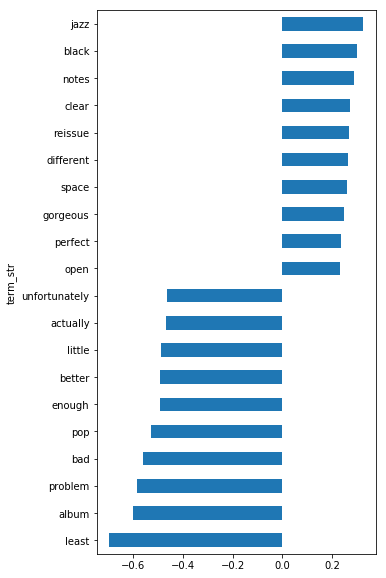

In [107]:
wpos = merge.valence.sort_values(ascending=False).head(10)
wneg = merge.valence.sort_values(ascending=False).tail(10)
pd.concat([wpos,wneg]).sort_values().plot.barh(figsize=(5,10))

## Expected mutual information 

In [108]:
training_tokens.head()

,doc_id,term_id,doc_label
0,19,33210,N
1,19,9635,N
2,19,22616,N
3,19,26766,N
4,19,19584,N


In [109]:
p_c = class_priors.to_frame()
p_c.columns = ['p']
p_c.index.name = 'doc_label'

In [110]:
p_c

,p
doc_label,
P,0.778824
N,0.221176


In [111]:
p_w = (training_tokens.term_id.value_counts() / training_tokens.shape[0]).to_frame()
p_w.columns = ['p']
p_w.index.name = 'term_id'
p_w['term_str'] = vocab.term_str

In [112]:
p_w.sort_values('p', ascending=False).head()

,p,term_str
term_id,,
22287,0.002681,like
1329,0.002432,album
26695,0.002374,one
25355,0.002252,music
13257,0.002118,even


In [113]:
p_cw = training_tokens.groupby(['term_id','doc_label']).count() / training_tokens.shape[0]
p_cw.columns = ['p']

In [114]:
p_cw.head()

p
term_id doc_label          
457     P          0.000011
460     N          0.000006
        P          0.000021
462     P          0.000004
464     N          0.000013

In [115]:
EMI = training_tokens.join(p_cw, on=['term_id','doc_label'], how='left').rename(columns={'p':'p_cw'})
EMI = EMI.join(p_w['p'], on='term_id', how='left').rename(columns={'p':'p_w'})
EMI = EMI.join(p_c, on='doc_label', how='left').rename(columns={'p':'p_c'})
EMI = EMI.join(vocab['term_str'], on='term_id', how='left')
EMI['emi'] = EMI.p_cw * log(EMI.p_cw/(EMI.p_c * EMI.p_w))
EMI = EMI[['doc_label','term_id','term_str','emi']].drop_duplicates().set_index(['doc_label','term_id'])

In [116]:
VN = EMI.loc['N'].sort_values('emi', ascending=False).head(100)

In [117]:
VP = EMI.loc['P'].sort_values('emi', ascending=False).head(100)

In [118]:
VP.head(10)

,term_str,emi
term_id,,
1492,also,0.000157
17090,guitar,0.000121
4139,black,0.000116
10607,different,0.000106
14511,first,0.000106
33969,set,0.000106
22231,life,0.000105
39057,together,0.000104
25355,music,0.000104


In [119]:
VN.head(10)

,term_str,emi
term_id,,
29666,problem,0.000187
40515,unfortunately,0.000169
21974,least,0.000127
2651,attempts,0.000122
42898,worse,0.000120
3028,bad,0.000113
42909,worst,0.000096
16001,generic,0.000089
19977,interesting,0.000081
